In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Bidirectional
from keras.layers import LSTM
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import recall_score
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import accuracy_score, confusion_matrix


# Partie 1

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_train.shape

(181763, 2)

In [4]:
df_train.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257


In [5]:
labels_count = df_train.ICD10.value_counts()

In [6]:
count_label = df_train.ICD10.value_counts()

In [7]:
labels_count[labels_count>10]

S062    1131
C798    1009
C859     800
C349     747
Z924     676
        ... 
M308      11
N027      11
O651      11
O621      11
M720      11
Name: ICD10, Length: 3726, dtype: int64

Text(0.5, 1.0, 'distribution de fréquence de classes')

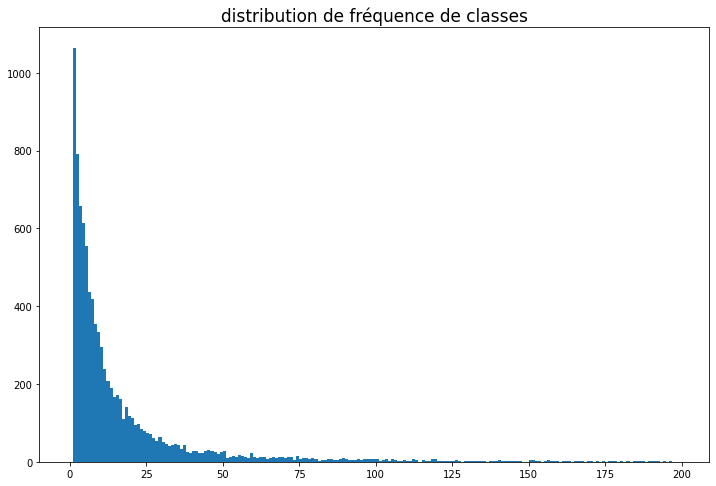

In [8]:
plt.figure(figsize=(12,8))
plt.hist(labels_count, bins= np.arange(0,200))
plt.title("distribution de fréquence de classes", fontsize = 17)

In [9]:
# Notre jeu des données est désequilibré : on a le 2/3 des classes qui sont apparus moins que 10 fois
# la classe la plus fréquente est apparus 1131 (S062)
# L'histrogramme montre bien que le dataset est déséquilibré 

[775, 8473]


<BarContainer object of 2 artists>

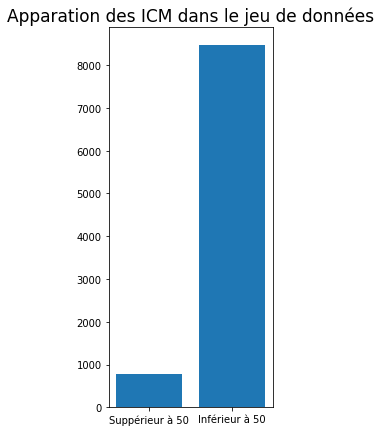

In [10]:
names = ['Suppérieur à 50', 'Inférieur à 50']

element  = sum( y > 49 for y in count_label.values )
values = [element, len(count_label.values)-element]
print(values)

plt.figure(figsize=(10, 7))

plt.subplot(131)
plt.title("Apparation des ICM dans le jeu de données", fontsize = 17)
plt.bar(names, values)

In [11]:
word_list = []
for text in df_train.RawText:
  words = text.split(" ")
  for w in words:
    word_list.append(w)
unique_word = list(set(word_list)) 
print("Nombre de mots : ",len(word_list))
print("Nombre de mots uniques: ",len(unique_word)) 

Nombre de mots :  659312
Nombre de mots uniques:  35602


In [12]:
# notre dictionnaire de mots contient 35602 mots differents.

In [13]:
# Vu que le jeu des données est completement désequilibré on va pas utiliser l'accuracy mais plutot le recall et la precision.
# (UAR, WAR)

# Partie 2

In [14]:
df_train_first_letter = df_train.copy()
df_train_first_letter.ICD10 = df_train_first_letter.ICD10.str.slice(0,1) 

In [15]:
df_train_first_letter.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I
1,Hémiplégie post-traumatique,S
2,Masculinisation avec hyperplasie surrénale,E
3,Hyperammoniémie cérébrale,E
4,Fistule artérioveineuse congénitale périphériq...,Q


<AxesSubplot:>

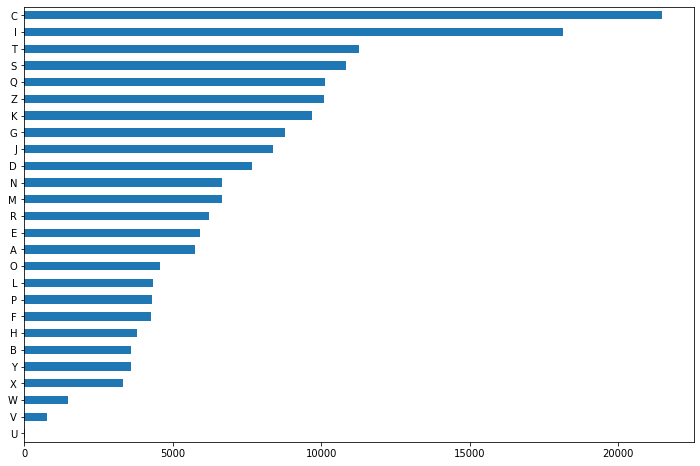

In [16]:
df_train_first_letter.ICD10.value_counts().sort_values().plot(figsize=(12,8), kind = 'barh')

Lorsqu'on prend seuelement la première lettre, on constate que le jeu de données est un peu moins déséquilibré.

In [17]:
df_val = pd.read_csv("val.csv")
df_val_first_letter = df_val.copy()
df_val_first_letter.ICD10 = df_val_first_letter.ICD10.str.slice(0,1)

In [18]:
#encodage des labels
label_encoder = LabelEncoder()

encoded_letters_train = label_encoder.fit_transform(df_train_first_letter.ICD10)
dummies_letters_train = tf.keras.utils.to_categorical(encoded_letters_train)

encoded_letters_val = label_encoder.transform(df_val_first_letter.ICD10)
dummies_letters_val = tf.keras.utils.to_categorical(encoded_letters_val)

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=35602, standardize = None)
vectorize_layer.adapt(df_train.RawText)

2021-12-16 22:36:13.955121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model_first_letter = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=35602, output_dim=100),
    tf.keras.layers.LSTM(50, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
    tf.keras.layers.LSTM(50, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=26, activation = "softmax")
])

In [ ]:
model_first_letter.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 100)         3560200   
                                                                 
 lstm (LSTM)                 (None, None, 50)          30200     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          20200     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 26)                1

In [ ]:
model_first_letter.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model_first_letter.fit(df_train.RawText, dummies_letters_train, validation_data=( df_val.RawText , dummies_letters_val), epochs=10,batch_size = 64 )


Epoch 1/10
2841/2841 [==============================] - 227s 78ms/step - loss: 0.4038 - accuracy: 0.8667 - val_loss: 0.6014 - val_accuracy: 0.8164
Epoch 2/10
2841/2841 [==============================] - 221s 78ms/step - loss: 0.3735 - accuracy: 0.8736 - val_loss: 0.6020 - val_accuracy: 0.8190
Epoch 3/10
2841/2841 [==============================] - 221s 78ms/step - loss: 0.3520 - accuracy: 0.8773 - val_loss: 0.6039 - val_accuracy: 0.8208
Epoch 4/10
2841/2841 [==============================] - 220s 77ms/step - loss: 0.3365 - accuracy: 0.8808 - val_loss: 0.6192 - val_accuracy: 0.8167
Epoch 5/10
2841/2841 [==============================] - 220s 77ms/step - loss: 0.3237 - accuracy: 0.8838 - val_loss: 0.6234 - val_accuracy: 0.8186
Epoch 6/10
2841/2841 [==============================] - 218s 77ms/step - loss: 0.3123 - accuracy: 0.8865 - val_loss: 0.6244 - val_accuracy: 0.8215
Epoch 7/10
2841/2841 [==============================] - 218s 77ms/step - loss: 0.3032 - accuracy: 0.8891 - val_loss: 0

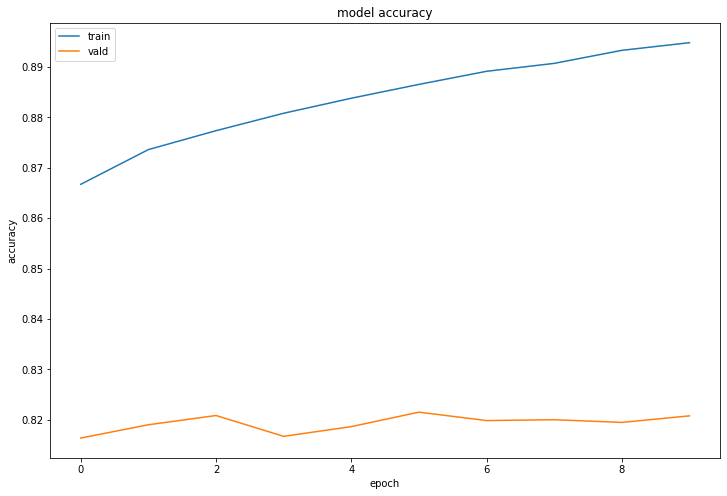

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

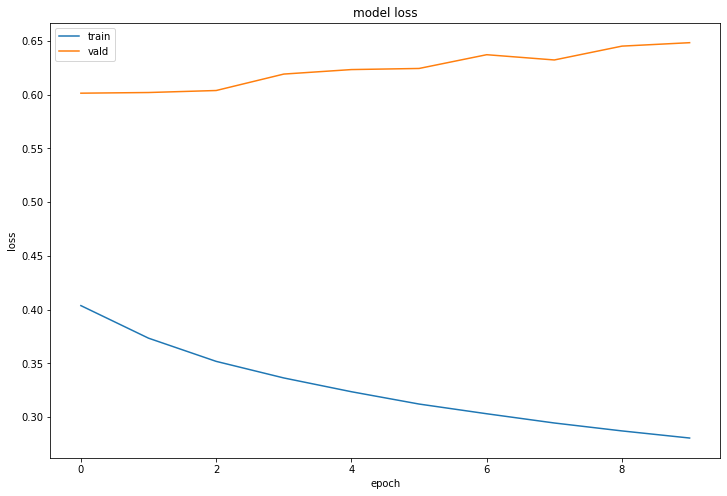

In [ ]:
# summarize history for loss
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

In [42]:
df_test = pd.read_csv("test.csv")
y_test_first_letter = df_test.ICD10.str.slice(0,1)

pred_test_first_letter = model_first_letter.predict(df_test.RawText).argmax(axis=1)
encoded_letters_test = label_encoder.transform(y_test_first_letter)


In [ ]:
print("accuracy score : ", accuracy_score(pred_test_first_letter,encoded_letters_test))
print("f1 score : " ,f1_score(pred_test_first_letter,encoded_letters_test,average='weighted'))
print("recall score : ", recall_score(pred_test_first_letter,encoded_letters_test,average='macro'))

accuracy score :  0.8234333333333334
f1 score :  0.8245147650876091
recall score :  0.8126541155857997


# Partie 3 

In [19]:
#Encodage des labels 

label_encoder_2 = LabelEncoder()

labels_to_predict = list(set(df_train.ICD10))

In [20]:
labels_with_unknown = labels_to_predict.copy()

In [21]:
labels_with_unknown.append("Unknown")

In [22]:
label_encoder_2.fit_transform(labels_with_unknown)

array([8058, 2449, 4742, ..., 7211, 8984, 8175])

In [23]:
encoded_all_letters_train = label_encoder_2.transform(df_train.ICD10)
dummies_all_letters_train = tf.keras.utils.to_categorical(encoded_all_letters_train)

In [24]:
new_labels_val = []
for label_val in df_val.ICD10.values : 
  if label_val in labels_to_predict :
    new_labels_val.append(label_val)
  else :
    new_labels_val.append("Unknown")
    
encoded_all_letters_val = label_encoder_2.transform(new_labels_val)
dummies_all_letters_val = tf.keras.utils.to_categorical(encoded_all_letters_val,  num_classes = 9249)



In [25]:
dummies_all_letters_train.shape

(181763, 9249)

In [ ]:
model_all_letter = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=35602, output_dim=150, mask_zero = True),
    tf.keras.layers.Conv1D(32, 3,activation="relu", input_shape = (None, 128)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.1, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(units=9249, activation = "softmax")
])

In [ ]:
model_all_letter.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model_all_letter.fit(df_train.RawText, dummies_all_letters_train,validation_data=( df_val.RawText , dummies_all_letters_val), batch_size = 64, epochs= 10 )

Epoch 1/10
2841/2841 [==============================] - 281s 98ms/step - loss: 7.1082 - accuracy: 0.0432 - val_loss: 5.7825 - val_accuracy: 0.1139
Epoch 2/10
2841/2841 [==============================] - 276s 97ms/step - loss: 4.7038 - accuracy: 0.1985 - val_loss: 4.1536 - val_accuracy: 0.2856
Epoch 3/10
2841/2841 [==============================] - 268s 94ms/step - loss: 3.2653 - accuracy: 0.3583 - val_loss: 3.4146 - val_accuracy: 0.3928
Epoch 4/10
2841/2841 [==============================] - 268s 94ms/step - loss: 2.4507 - accuracy: 0.4723 - val_loss: 3.1001 - val_accuracy: 0.4527
Epoch 5/10
2841/2841 [==============================] - 307s 108ms/step - loss: 1.9649 - accuracy: 0.5510 - val_loss: 2.9840 - val_accuracy: 0.4940
Epoch 6/10
2841/2841 [==============================] - 309s 109ms/step - loss: 1.6400 - accuracy: 0.6087 - val_loss: 2.9109 - val_accuracy: 0.5126
Epoch 7/10
2841/2841 [==============================] - 309s 109ms/step - loss: 1.4118 - accuracy: 0.6514 - val_loss

In [ ]:
pred_train_all_letter = model_all_letter.predict(df_train.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_train_all_letter ,encoded_all_letters_train))
print("f1 score : " ,f1_score(pred_train_all_letter ,encoded_all_letters_train,average='weighted'))
print("recall score : ", recall_score(pred_train_all_letter ,encoded_all_letters_train, average='macro'))

accuracy score :  0.8088059726126879
f1 score :  0.814076241609965
recall score :  0.7992341852610686


/Users/akhalbous/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_val_all_letter = model_all_letter.predict(df_val.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_val_all_letter ,encoded_all_letters_val))
print("f1 score : " ,f1_score(pred_val_all_letter ,encoded_all_letters_val,average='weighted'))
print("recall score : ", recall_score(pred_val_all_letter ,encoded_all_letters_val, average='macro'))

accuracy score :  0.5527666666666666
f1 score :  0.5627254181043442
recall score :  0.42384708451286696


/Users/akhalbous/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
df_test = pd.read_csv("test.csv")
new_labels_test = []
for label_test in df_test.ICD10.values : 
  if label_test in labels_to_predict :
    new_labels_test.append(label_test)
  else :
    new_labels_test.append("Unknown")
    
encoded_all_letters_test = label_encoder_2.transform(new_labels_test)

In [ ]:
pred_test_all_letter = model_all_letter.predict(df_test.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_test_all_letter ,encoded_all_letters_test))
print("f1 score : " ,f1_score(pred_test_all_letter ,encoded_all_letters_test,average='weighted'))
print("recall score : ", recall_score(pred_test_all_letter ,encoded_all_letters_test, average='macro'))

accuracy score :  0.5488333333333333
f1 score :  0.5581020461112427
recall score :  0.42924567725787527


/Users/akhalbous/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


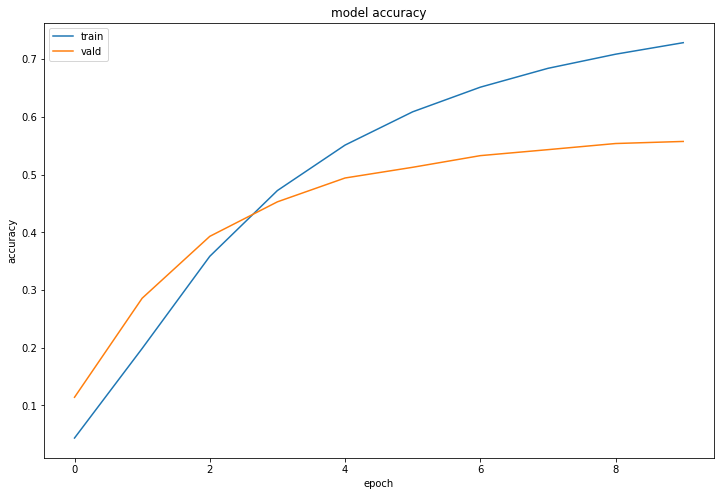

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

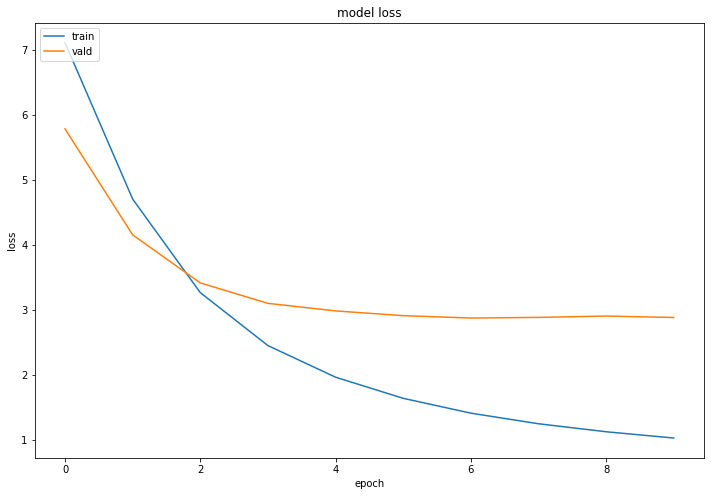

In [ ]:
# summarize history for loss
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

In [ ]:
length = len(pred_test_all_letter)
pred_lab = list(label_encoder_2.inverse_transform(pred_test_all_letter ))

In [ ]:
def calculate_acc(data_length,predicted,label,compare_length):
  correct = 0
  for i in range(data_length):
    if predicted[i][:compare_length] in label[i][:compare_length]:
      correct+=1
  return correct/data_length

In [ ]:
acc_one_letter = calculate_acc(length,pred_lab,df_test.ICD10,1)
acc_one_letter

0.7670666666666667

In [ ]:
acc_two_letter = calculate_acc(length,pred_lab,df_test.ICD10,2)
acc_two_letter

0.6963333333333334

In [ ]:
acc_three_letter = calculate_acc(length,pred_lab,df_test.ICD10,3)
acc_three_letter

0.6353666666666666

# Partie 5

## Lematization

In [30]:
!python3 -m spacy download fr_core_news_md

     |████████████████████████████████| 46.9 MB 71 kB/s eta 0:00:012    |███▎                            | 4.8 MB 94 kB/s eta 0:07:25     |█████▉                          | 8.6 MB 26 kB/s eta 0:24:13
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [28]:
!pip3 install spacy

     |████████████████████████████████| 6.3 MB 72 kB/s eta 0:00:011
     |████████████████████████████████| 2.7 MB 163 kB/s eta 0:00:01
     |████████████████████████████████| 106 kB 86 kB/s eta 0:00:01
     |████████████████████████████████| 452 kB 84 kB/s eta 0:00:011
     |████████████████████████████████| 5.8 MB 66 kB/s eta 0:00:015
     |████████████████████████████████| 181 kB 83 kB/s eta 0:00:01
     |████████████████████████████████| 42 kB 51 kB/s eta 0:00:01
     |████████████████████████████████| 615 kB 46 kB/s eta 0:00:01
     |████████████████████████████████| 133 kB 118 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 95 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 52 kB/s eta 0:00:01


In [31]:
import spacy

nlp = spacy.load('fr_core_news_md')


In [32]:
def lemmatize_sentence(df):
  s = df
  doc = nlp(s)
  l = " ".join([token.lemma_ for token in doc])
  return l
df_train2 = df_train.copy()

df_train2["RawText"]= df_train2.RawText.apply(lemmatize_sentence)
df_train2

,RawText,ICD10
0,thrombose veineux profond cuisse gauche,I802
1,hémiplégie post-traumatiqu,S099
2,masculinisation avec hyperplasie surrénal,E250
3,hyperammoniémie cérébral,E722
4,fistule artérioveineus congénital périphérique...,Q257
...,...,...
181758,Prématurité 32 sa,P073
181759,rétinopathie e14.3 malnutrition e12.3,H360
181760,métastase pariétal,C798
181761,lésion cutané de le pinta,A673


In [33]:
df_val2 = df_val.copy()
df_val2["RawText"]= df_val.RawText.apply(lemmatize_sentence)
df_val2

,RawText,ICD10
0,incompétence cardiaque gauche,I501
1,carcinome voie urinaire supérieur,C689
2,vih voie respiratoire devoir à agent externe p...,J708
3,hématome bra,S400
4,ligature carotide gauche,Z924
...,...,...
29995,thrombose artère cérébral moyen,I660
29996,paralysie périodique familial,G723
29997,carbonisation corp,X09
29998,carcinome amygdal et plancher buccal,C148


In [48]:
df_test2 = df_val.copy()
df_test2["RawText"]= df_test.RawText.apply(lemmatize_sentence)

In [34]:
word_list = []
for text in df_train2.RawText:
  words = text.split(" ")
  for w in words:
    word_list.append(w)
unique_word = list(set(word_list)) 
print("Nombre de mots : ",len(word_list))
print("Nombre de mots uniques: ",len(unique_word)) 


Nombre de mots :  711528
Nombre de mots uniques:  28282


In [35]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=len(unique_word), standardize = None)
vectorize_layer.adapt(df_train2.RawText)

2021-12-17 20:02:08.291228: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [61]:
model_all_letter_lemm = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(unique_word), output_dim=150, mask_zero = True),
    tf.keras.layers.Conv1D(32, 3,activation="relu", input_shape = (None, 128)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.1, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(units=9249, activation = "softmax")
])

In [62]:
model_all_letter_lemm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_lemm = model_all_letter_lemm.fit(df_train2.RawText, dummies_all_letters_train, validation_data=( df_val2.RawText , dummies_all_letters_val), batch_size = 64, epochs= 10 )

Epoch 1/10
2841/2841 [==============================] - 268s 92ms/step - loss: 6.9873 - accuracy: 0.0522 - val_loss: 5.6023 - val_accuracy: 0.1288
Epoch 2/10
2841/2841 [==============================] - 282s 99ms/step - loss: 4.6133 - accuracy: 0.2129 - val_loss: 4.0227 - val_accuracy: 0.2923
Epoch 3/10
2841/2841 [==============================] - 306s 108ms/step - loss: 3.2458 - accuracy: 0.3610 - val_loss: 3.2792 - val_accuracy: 0.3953
Epoch 4/10
2841/2841 [==============================] - 312s 110ms/step - loss: 2.4584 - accuracy: 0.4703 - val_loss: 2.9433 - val_accuracy: 0.4665
Epoch 5/10
2841/2841 [==============================] - 301s 106ms/step - loss: 1.9869 - accuracy: 0.5433 - val_loss: 2.7950 - val_accuracy: 0.4989
Epoch 6/10
2841/2841 [==============================] - 273s 96ms/step - loss: 1.6802 - accuracy: 0.5966 - val_loss: 2.7112 - val_accuracy: 0.5248
Epoch 7/10
2841/2841 [==============================] - 281s 99ms/step - loss: 1.4593 - accuracy: 0.6390 - val_loss

In [67]:
pred_train_all_letter_lemm = model_all_letter_lemm.predict(df_train2.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_train_all_letter_lemm ,encoded_all_letters_train))
print("f1 score : " ,f1_score(pred_train_all_letter_lemm ,encoded_all_letters_train,average='weighted'))
print("recall score : ", recall_score(pred_train_all_letter_lemm ,encoded_all_letters_train, average='macro'))

accuracy score :  0.792911648685376
f1 score :  0.7977127337348682
recall score :  0.7851185356805737


In [65]:
pred_val_all_letter_lemm = model_all_letter_lemm.predict(df_val2.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_val_all_letter_lemm ,encoded_all_letters_val))
print("f1 score : " , f1_score(pred_val_all_letter_lemm ,encoded_all_letters_val,average='weighted'))
print("recall score : ", recall_score(pred_val_all_letter_lemm ,encoded_all_letters_val, average='macro'))

accuracy score :  0.5628333333333333
f1 score :  0.5683841202023148
recall score :  0.431817642619295


In [64]:
pred_test_all_letter_lemm = model_all_letter_lemm.predict(df_test2.RawText).argmax(axis=1)
print("accuracy score : ", accuracy_score(pred_test_all_letter_lemm ,encoded_all_letters_test))
print("f1 score : " ,f1_score(pred_test_all_letter_lemm ,encoded_all_letters_test,average='weighted'))
print("recall score : ", recall_score(pred_test_all_letter_lemm ,encoded_all_letters_test, average='macro'))

accuracy score :  0.5582
f1 score :  0.5648449728297785
recall score :  0.4237386333440339


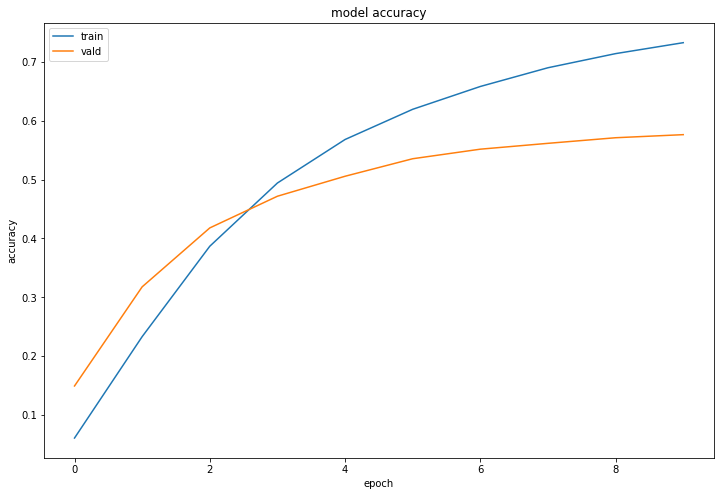

In [56]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_lemm.history['accuracy'])
plt.plot(history_lemm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()

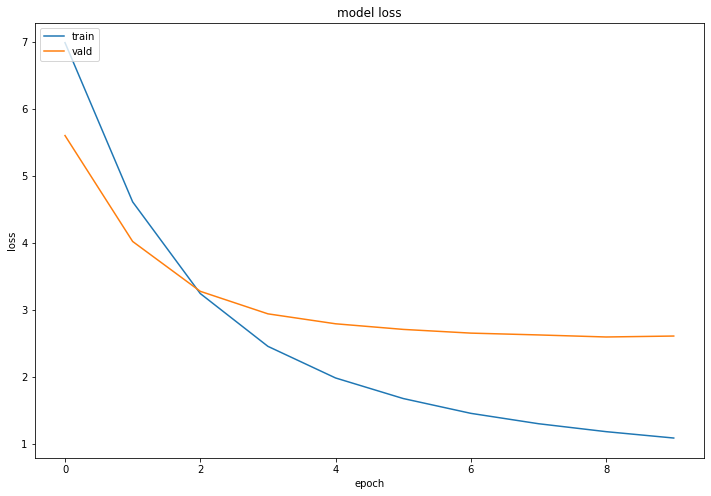

In [63]:
# summarize history for loss
plt.figure(figsize = (12,8))
plt.plot(history_lemm.history['loss'])
plt.plot(history_lemm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vald'], loc='upper left')
plt.show()